Produces heatmap data for Fig 3 E and F.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import scanpy as sc
from tqdm import tnrange, tqdm_notebook
import matplotlib.backends.backend_pdf
from IPython.display import clear_output

import scvelo as scv
scv.settings.set_figure_params('scvelo', dpi_save=200, dpi=40, transparent=True)
scv.settings.verbosity = 0
sc.settings.verbosity=0

/fast/users/peidlis_c/work/miniconda/envs/py36/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
data_path='/fast/scratch/users/peidlis_c/sodar_patient_organoid_data/'
signatures_path='/fast/work/users/peidlis_c/projects/sodar_patient_organoid_data/signatures/'

In [3]:
# celltype markers
tab = pd.read_csv(signatures_path + 'cell_type_markers/cell_type_markers_epi.tsv', sep='\t')
tab = tab[tab.p_val_adj<0.01]
tab = tab[np.abs(tab.avg_logFC)> 0.75]
cell_types = pd.unique(tab.cell_type_epi)
cell_types = cell_types[cell_types!='Stem/TA 2']
cell_types = cell_types[cell_types!='Stem/TA 3']
cell_types = cell_types[cell_types!='Imma. Gob. 1']
cell_types = cell_types[cell_types!='TC2']
signature=dict([(ct, tab.gene.values[tab.cell_type_epi==ct]) for ct in cell_types])

# Fig 3E: latent time heatmap

In [4]:
def heatmap_obs(adata, obs_keys, tkey='pseudotime', xkey='Ms', color_map='viridis', col_color=None, n_convolve=30,
            standard_scale=0, sort=True, colorbar=None, col_cluster=False, row_cluster=False,
            figsize=(10, 5), show=True, save=None, ax=None, title=None, vmin=None, vmax=None):

    import seaborn as sns
    from scvelo.plotting.utils import savefig_or_show
    
    time = adata.obs[tkey].values
    time = time[np.isfinite(time)]

    df = pd.DataFrame(adata.obs[obs_keys].iloc[np.argsort(time)], columns=obs_keys)

    if n_convolve is not None:
        weights = np.ones(n_convolve) / n_convolve
        for i, gene in enumerate(obs_keys):
            df[gene] = np.convolve(df[gene].values, weights, mode='same')

    if sort:
        max_sort = np.argsort(np.argmax(df.values, axis=0))
        df = pd.DataFrame(df.values[:, max_sort], columns=df.columns[max_sort])
    if col_color is not None: col_color = interpret_colorkey(adata, col_color)[np.argsort(time)]
    cm = sns.clustermap(df.T, col_colors=col_color, col_cluster=col_cluster, row_cluster=row_cluster, cmap=color_map, yticklabels=True,
                        xticklabels=False, standard_scale=standard_scale, figsize=figsize, vmin=vmin, vmax=vmax)
    cm.ax_heatmap.set_title(title)
    if not colorbar: cm.cax.set_visible(False)
    savefig_or_show('heatmap', save=save, show=show)
    if not show: return ax
    pl.show()

In [5]:
from matplotlib.colors import is_color_like, ListedColormap, to_rgb, cnames
def rgb_custom_colormap(colors=['royalblue', 'white', 'forestgreen'], alpha=None, N=256):
    """Creates a custom colormap with the given colors. Colors can be given as names or as rgb values.

    Arguments
    ---------
    colors: : `list` or `array` (default `['royalblue', 'white', 'forestgreen']`)
        List of colors, either as names or rgb values.
    alpha: `list`, `np.ndarray` or `None` (default: `None`)
        Alpha of the colors. Must be same length as colors.
    N: `int` (default: `256`)
        y coordinate

    Returns
    -------
        A ListedColormap
    """
   
    
    c = []
    for color in colors:
        if type(color) is str:
            c.append(to_rgb(cnames[color]))

    vals = np.ones((N, 4))
    ints = len(c) - 1
    n = int(N / ints)

    alpha = np.ones(len(c)) if alpha is None else alpha

    for j in range(ints):
        for i in range(3):
            vals[n * j:n * (j + 1), i] = np.linspace(c[j][i], c[j + 1][i], n)
        vals[n * j:n * (j + 1), -1] = np.linspace(alpha[j], alpha[j + 1], n)
    return ListedColormap(vals)

In [17]:
for donor in ['NCO', 'p009ot', 'p013ot']:
    for letter in ['E', 'W']:
        df = pd.read_csv(data_path+'progeny_scores/NB_AS_'+letter+'_'+donor+'_progeny_scores.csv', index_col=0)
        print(np.max(np.percentile(df, 95, axis=0)))
        print(np.min(np.percentile(df, 5, axis=0)))

2.034004382181399
-1.8234373880283141
2.05537395567455
-1.88048258551243
1.6807396168514142
-1.920049573518182
1.8258149655832505
-1.8145877434562818
1.8307126932984572
-2.059625389611427
1.6925836925088757
-1.8981944805955377


[False False False ... False False False]
[  65  932   35 ... 1368  907  148]


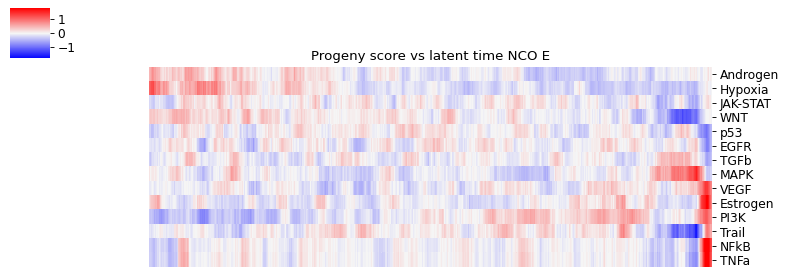

In [28]:
donor='NCO'
letter='E'

adata = scv.read(data_path+'NB_AS_'+letter+'/processed/NB_AS_'+letter+'_'+donor+'SLAMvelo.h5')
scv.tl.recover_latent_time(adata)
df = pd.read_csv(data_path+'progeny_scores/NB_AS_'+letter+'_'+donor+'_progeny_scores.csv', index_col=0)
adata.obs = pd.concat([adata.obs, df], axis=1, sort=False)
obs_keys = list(df.columns)
k = len(obs_keys)

my_cmap=rgb_custom_colormap(colors=['blue', 'whitesmoke', 'red'])
heatmap_obs(adata, obs_keys, tkey='latent_time', figsize=(10,5*k/20), title='Progeny score vs latent time '+donor+' '+letter, 
            standard_scale=None, colorbar=True, vmin=-1.8, vmax=1.8, color_map=my_cmap)#, save='LTH_PROGENYSCORES'+donor+letter+'.png')

[False False False ... False False False]
[  65  932   35 ... 1368  907  148]


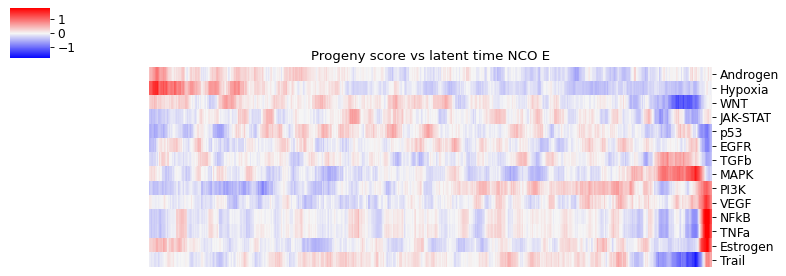

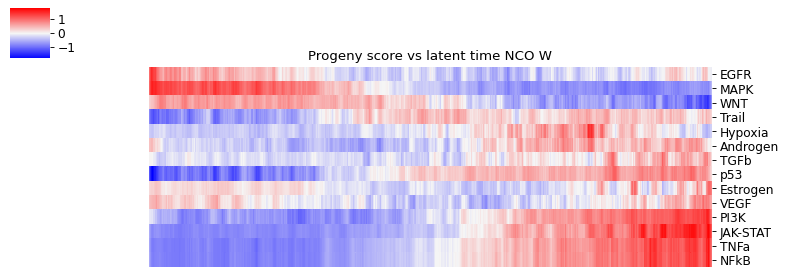

[False False False ... False False False]
[1772   46 1800 ... 1594 1639 1761]


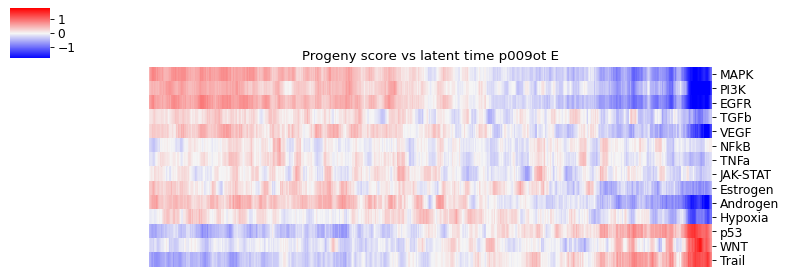

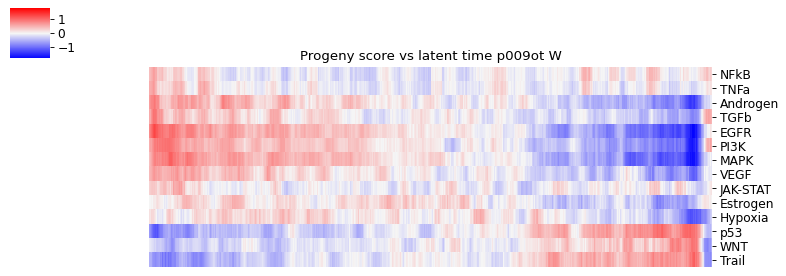

[False False False ... False False False]
[ 501  488  900 ...  977 1258  518]


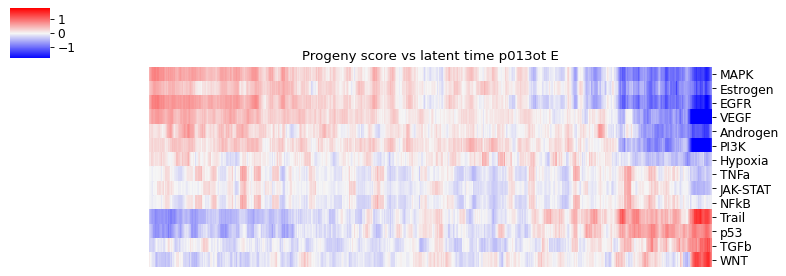

[False False False ... False False False]
[1530 1078 1511 ... 2781 2851 2435]


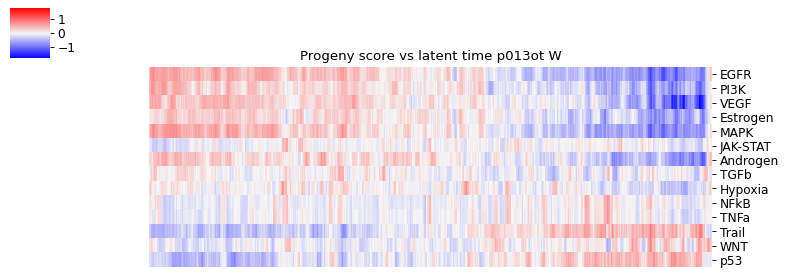

In [6]:
# progeny scores
my_cmap=rgb_custom_colormap(colors=['blue', 'whitesmoke', 'red'])
for donor in ['NCO', 'p009ot', 'p013ot']:
    for letter in ['E', 'W']:
        adata = scv.read(data_path+'NB_AS_'+letter+'/processed/NB_AS_'+letter+'_'+donor+'SLAMvelo.h5')
        scv.tl.recover_latent_time(adata)
        df = pd.read_csv(data_path+'progeny_scores/NB_AS_'+letter+'_'+donor+'_progeny_scores.csv', index_col=0)
        adata.obs = pd.concat([adata.obs, df], axis=1, sort=False)
        obs_keys = list(df.columns)
        k = len(obs_keys)
        heatmap_obs(adata, obs_keys, tkey='latent_time', figsize=(10,5*k/20), title='Progeny score vs latent time '+donor+' '+letter, 
                    save='LTH_PROGENYSCORES'+donor+letter+'.png', standard_scale=None, colorbar=True, vmin=-1.8, vmax=1.8, color_map=my_cmap)

# Export data for Fig 3E

In [ ]:
mgs=['FABP1', 'TFF3', 'OLFM4', 'LGR5', 'MMP7', 'MKI67']

tab = pd.read_csv(signatures_path + 'cell_type_markers/cell_type_markers_epi.tsv', sep='\t')
tab = tab[tab.p_val_adj<0.01]
tab = tab[np.abs(tab.avg_logFC)> 0.75]
cell_types = pd.unique(tab.cell_type_epi)
cell_types = cell_types[cell_types!='Stem/TA 2']
cell_types = cell_types[cell_types!='Stem/TA 3']
cell_types = cell_types[cell_types!='Imma. Gob. 1']
cell_types = cell_types[cell_types!='TC2']
signature1=dict([(ct, tab.gene.values[tab.cell_type_epi==ct]) for ct in cell_types])

tab = pd.read_csv(signatures_path+'targets/progeny_pathways.csv', sep='\t', header=0)
signature2 = dict([(ids, tab[tab['#Pathway']==ids].Gene_Name.values) for ids in pd.unique(tab['#Pathway'])])

tab = pd.read_excel(signatures_path+'cell_type_markers/CRC-related_stem_cell_signatures.xlsx', index_col=None, header=0, skiprows=[1])
signature3 = dict([(ids, tab[ids][~pd.isna(tab[ids])].values) for ids in tab.columns])

In [ ]:
# export for Fig5D:
dfs=[]
for donor in ['NCO', 'p009ot', 'p013ot']:
    for letter in ['E', 'W']:
        adata = scv.read(data_path+'NB_AS_'+letter+'/processed/NB_AS_'+letter+'_'+donor+'SLAMvelo.h5')
        var_names = [name for name in mgs if name in adata.var_names]
        
        for signature in [signature1, signature2, signature3]:
            for ids in signature.keys():   
                genes = signature[ids]
                genes = [genes] if np.isscalar(genes) else genes
                sc.tl.score_genes(adata, genes, score_name=ids, use_raw=False)
        
        # get data
        scv.tl.recover_latent_time(adata)
        time = adata.obs['latent_time'].values
        time = time[np.isfinite(time)]
        data = adata[:, var_names].layers['Ms']
        
        idx = list(signature1.keys()) + list(signature2.keys()) + list(signature3.keys())
        
        df=pd.DataFrame(np.vstack([time.T, data.T,
                                  adata.obs[idx].values.T
                                  ]).T, columns=['latent_time']+var_names+idx)
        df=df.sort_values('latent_time')
        dfs.append(df)
#         df.to_csv('/fast/scratch/groups/ag_bluethgen/Stefan/latent_time_export/fullexport_against_latenttime'+donor+letter+'.csv')